1. End-to-End Machine Learning Project

1.1. Get the Data
Rather than manually downloading and decompressing the data, it’s usually preferable to write a function that does it for you. Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# Downloads file from the ageron/data GitHub repository, and extracts its content into the datasets directory
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_housing_data()

Take a quick look at the data structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes. The info() method is useful to get a quick description of the data, in particular the total number of rows, each attribute’s type, and the number of non-null values:

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


ocean_proximity column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the value_counts() method:

In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Let’s look at the other fields. The describe() method shows a summary of the numerical attributes

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute

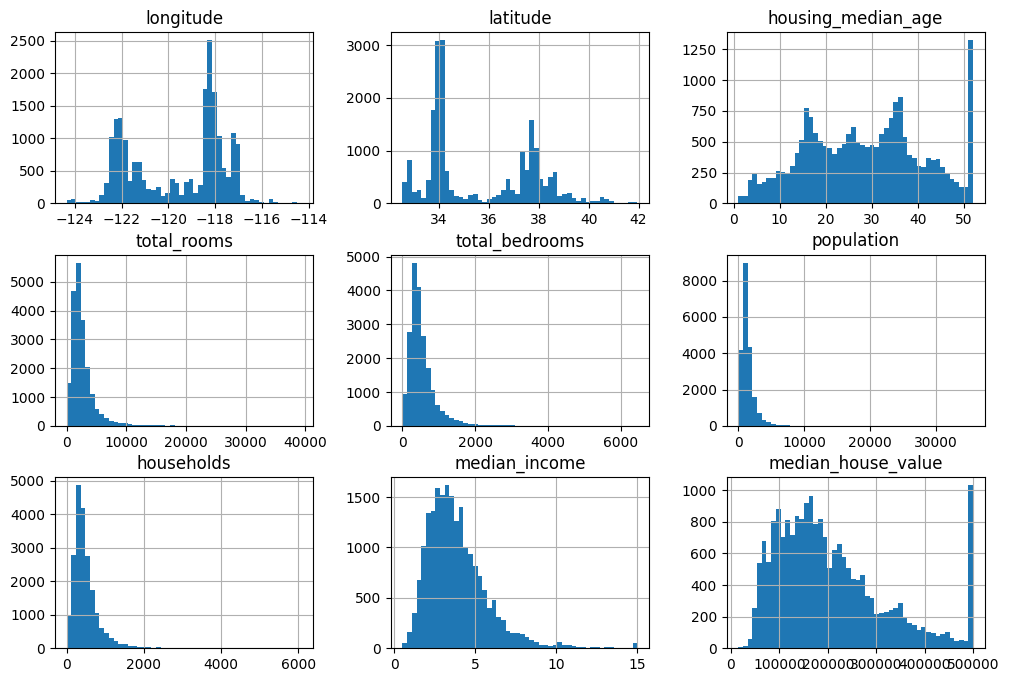

In [21]:
import matplotlib.pyplot as plt
# bins is the resolution of the data, greater values of bins results in more resolution of the histograms, but it tooks more time to complete the calculation. 
# figsize=(x,y) x are the width of the total plot and y is the height
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Looking at these histograms, you notice a few things:

1. The median income attribute does not look like it is expressed in US dollars (USD). the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. Working with preprocessed attributes is common in machine learning. You should try to understand how the data was computed.

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels).

3. These attributes have very different scales.

4. Many histograms are skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some machine learning algorithms to detect patterns.

Wait! Before you look at the data any further, you need to create a test set, put it aside, and never look at it. Your brain is an amazing pattern detection system, which also means that it is highly prone to overfitting. This is called data snooping bias

1.2. Create a Test Set
Creating a test set is theoretically simple; pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [22]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # creates a random sequence based on data length. ie: [0, 1, 2, 3] --> [3, 1, 0, 2]
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # first indices
    train_indices = shuffled_indices[test_set_size:] # rest of the indices
    return data.iloc[train_indices], data.iloc[test_indices] # return data based on the indices of each subset indices

You can then use this function like this:

In [26]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(f'train_set length: {len(train_set)} | test_set length: {len(test_set)} | housing_set length: {len(housing)}')

train_set length: 16512 | test_set length: 4128 | housing_set length: 20640


This works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your machine learning algorithms) will get to see the whole dataset, which is what you want to avoid.

1. One solution is to save the test set on the first run and then load it in subsequent runs.
2. Another option is to set the random number generator’s seed (e.g., with np.random.seed(42))⁠ before calling np.random.permutation() so that it always generates the same shuffled indices.

However, both these solutions will break the next time you fetch an updated dataset. To have a stable train/test split even after updating the dataset, a common solution is:

3. Use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have unique and immutable identifiers).

Here is a possible implementation:

In [66]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column] # select the column with the indices
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set] # ~ inverts boolean values

The housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [67]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [68]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split(). there is a random_state parameter that allows you to set the random generator seed. Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):

In [73]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. You may want to ensure that the test set is representative of the various categories. This means that you should not have too many strata, and each stratum should be large enough.

The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5); category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [74]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

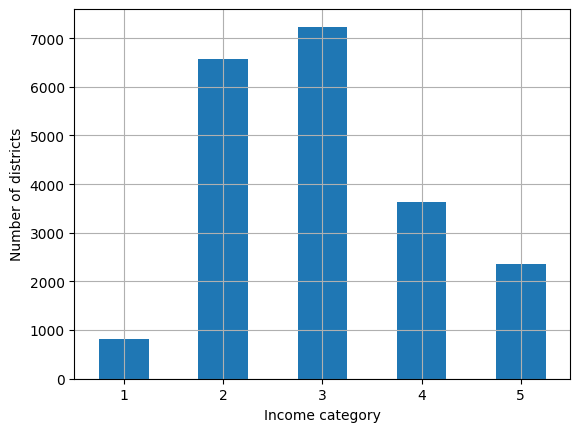

In [75]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Scikit-Learn provides a number of splitter classes in the sklearn.model_selection package that implement various strategies to split your dataset into a training set and a test set. Each splitter has a split() method that returns an iterator over different training/test splits of the same data. To be precise, the split() method yields the training and test indices, not the data itself.

Having multiple splits can be useful if you want to better estimate the performance of your model (crossvalidation). For example, the following code generates 10 different stratified splits of the same dataset:

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

We can use the first split:

In [77]:
strat_train_set, strat_test_set = strat_splits[0]

Or, since stratified sampling is fairly common, there’s a shorter way to get a single split using the train_test_split() function with the stratify argument:

In [78]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [79]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

You won’t use the income_cat column again, so you might as well drop it, reverting the data back to its original state:

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

We spent quite a bit of time on test set generation for a good reason: this is an often neglected but critical part of a machine learning project.

1.3. Explore and Visualize the Data to gain Insights
So far we have only taken a quick glance at the data to get a general understanding of the kind of data we are manipulating. Now the goal is to go into a little more depth. 

First, we make sure to put the test set aside and we are only exploring the training set. Also, if the training set is very large, we may want to sample an exploration set, to make manipulations easy and fast during the exploration phase.

In [89]:
housing = strat_train_set.copy()

1.3.1 Visualizing Geographical Data
Because the dataset includes geographical information (latitude and longitude), it is a good idea to create a scatterplot of all the districts to visualize the data:

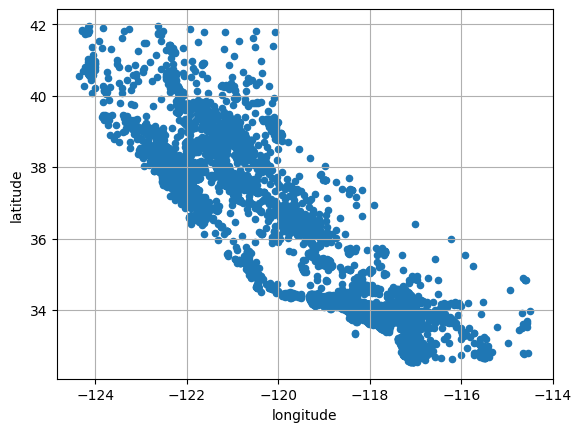

In [81]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

Setting the alpha option to 0.2 makes it much easier to visualize the places where there is a high density of data points:

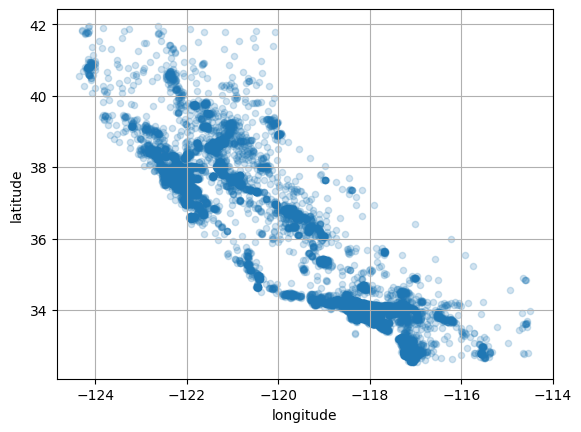

In [82]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

Next, the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). Here you use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

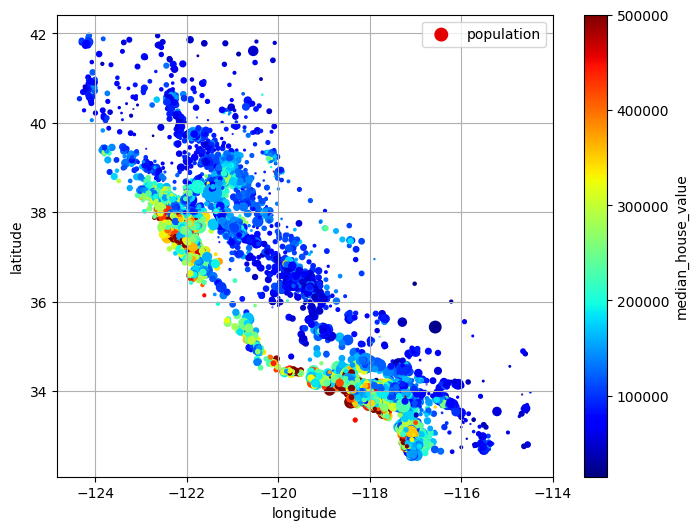

In [85]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=housing["population"] / 100, label="population",
c="median_house_value", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(8, 6))
plt.show()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

1.3.2. Look for correlations
Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method:

In [96]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation.

Another way to check for correlation between attributes is to use the Pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 11 = 121 plots, which would not fit on a page—so you decide to focus on a few promising attributes that seem most correlated with the median housing value:

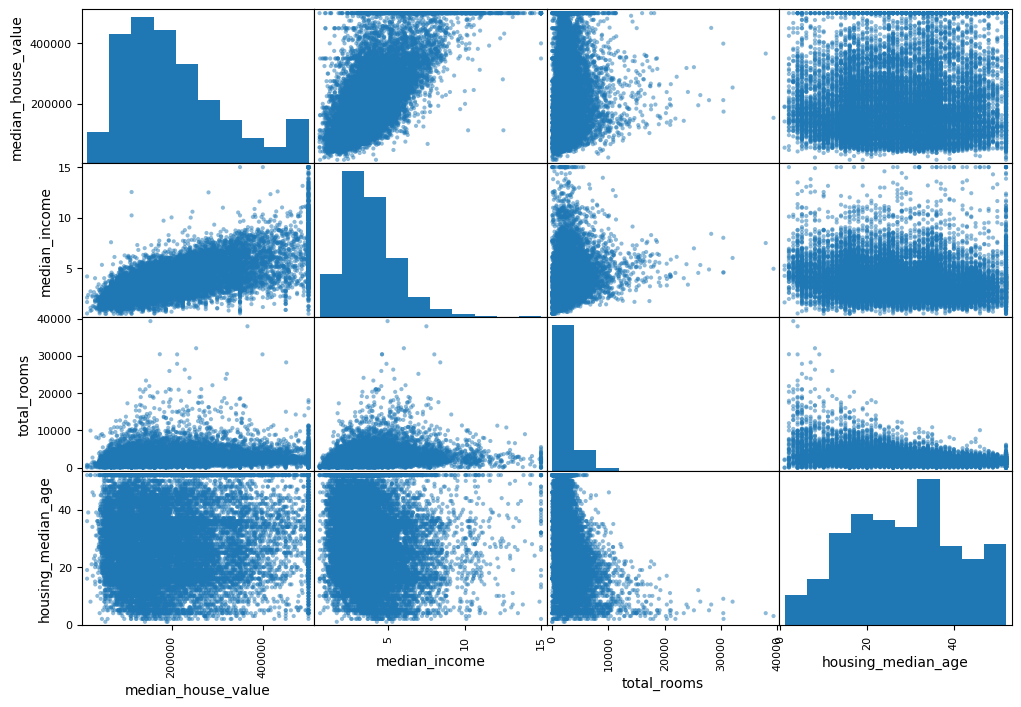

In [91]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

The most promising attribute to predict the median house value is the median income:

<Axes: xlabel='median_income', ylabel='median_house_value'>

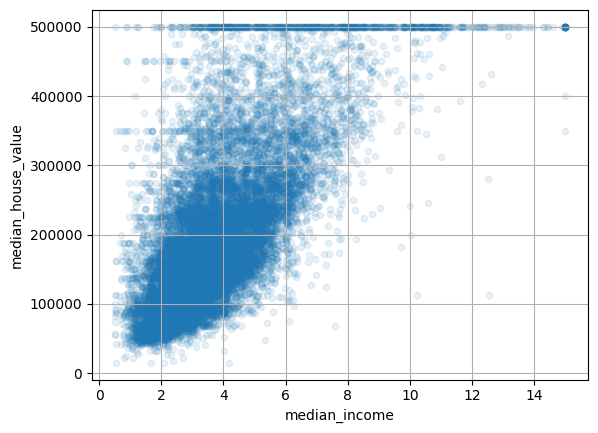

In [93]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1, grid=True)

1. The correlation is strong
2. There is a price cap

You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

Warning! 
The correlation coefficient only measures linear correlations (“as x goes up, y generally goes up/down”). It may completely miss out on nonlinear relationships.

1.3.3. Experiment with Attribute Combinations
Your mileage will vary considerably with each project, but the general ideas are similar. One last thing you may want to do before preparing the data for machine learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. You create these new attributes as follows:

In [94]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [97]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

The new bedrooms_ratio attribute is much more correlated with the median house value than the total number of rooms or bedrooms. This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help

1.3.4. Prepare the Data for Machine Learning Algorithms
It’s time to prepare the data for your machine learning algorithms. Instead of doing this manually, you should write functions for this purpose.

1. This will allow you to reproduce these transformations
2. You will gradually build a library of transformation functions
3. You can use these functions in your live system to transform the new data
4. This will make it possible for you to easily try various transformations

But first, revert to a clean training set (by copying strat_train_set once again). You should also separate the predictors and the labels, since you don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):

In [98]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

1.3.4.1 Clean the Data
Most machine learning algorithms cannot work with missing features, so you’ll need to take care of these.

In [ ]:
housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3 --> less destructive
housing["total_bedrooms"].fillna(median, inplace=True)

In [99]:
median = housing["total_bedrooms"].median() # option 3 --> less destructive
housing["total_bedrooms"].fillna(median, inplace=True)

C:\Users\U2301020\AppData\Local\Temp\ipykernel_4288\4097738641.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


For each option, we'll create a copy of housing and work on that copy to avoid breaking housing.

In [100]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [102]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

C:\Users\U2301020\AppData\Local\Temp\ipykernel_4288\3218827148.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


You decide to go for option 3 since it is the least destructive, but instead of the preceding code, you will use a handy Scikit-Learn class: SimpleImputer. The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model. To use it, first you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [103]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you then need to create a copy of the data with only the numerical attributes (this will exclude the text attribute ocean_proximity):

In [105]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


Now you can fit the imputer instance to the training data using the fit() method:

In [106]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but you cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [107]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [108]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [112]:
X = imputer.transform(housing_num)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

Missing values can also be replaced with the mean value (strategy="mean"), or with the most frequent value (strategy="most_frequent"), or with a constant value (strategy="constant", fill_value=…). The last two strategies support non-numerical data.

There are also more powerful imputers available in the sklearn.impute package (both for numerical features only):

1. KNNImputer replaces each missing value with the mean of the k-nearest neighbors values for that feature. The distance is based on all the available features
2. IterativeImputer trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matrices) even when they are fed Pandas DataFrames as input.⁠ So, the output of imputer.transform(housing_num) is a NumPy array: X has neither column names nor index. Luckily, it’s not too hard to wrap X in a DataFrame and recover the column names and index from housing_num:

In [111]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

1.3.4.2 Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but your data may also contain text attributes. In this dataset, there is just one: the ocean_proximity attribute.

In [113]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


This attribute is a categorical attribute. Most machine learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class:

In [114]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

You can get the list of categories using the categories_ instance variable. It is a list containing a 1D array of categories for each categorical attribute

In [115]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is " <1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:

In [116]:
from sklearn.preprocessing import OneHotEncoder 

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the output of a OneHotEncoder is a SciPy sparse matrix, instead of a NumPy array. A sparse matrix is a very efficient representation for matrices that contain mostly zeros.

In this case, a sparse matrix is exactly what you need: it will save plenty of memory and speed up computations. You can use a sparse matrix mostly like a normal 2D array,⁠ but if you want to convert it to a (dense) NumPy array, just call the toarray() method:

In [117]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set sparse=False when creating the OneHotEncoder, in which case the transform() method will return a regular (dense) NumPy array directly. 

As with the OrdinalEncoder, you can get the list of categories using the encoder’s categories_ instance variable:

In [118]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas has a function called get_dummies(), which also converts each categorical feature into a one-hot representation, with one binary feature per category:

In [120]:
df_test = pd.DataFrame({'ocean_proximity': ['INLAND', 'NEAR BAY']})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


It looks nice and simple, so why not use it instead of OneHotEncoder? Well, the advantage of OneHotEncoder is that it remembers which categories it was trained on. This is very important because once your model is in production, it should be fed exactly the same features as during training. Look what our trained cat_encoder outputs when we make it transform the same df_test (using transform(), not fit_transform()):

In [122]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

See the difference? get_dummies() saw only two categories, so it output two columns, whereas OneHotEncoder output one column per learned category, in the right order. Moreover, if you feed get_dummies() a DataFrame containing an unknown category (e.g., "<2H OCEAN"), it will happily generate a column for it:

In [123]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


But OneHotEncoder is smarter: it will detect the unknown category and raise an exception. If you prefer, you can set the handle_unknown hyperparameter to "ignore", in which case it will just represent the unknown category with zeros:

In [125]:
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you can use one of the encoders provided by the category_encoders package on GitHub. Or, when dealing with neural networks, you can replace each category with a learnable, low-dimensional vector called an embedding. This is an example of representation learning.

When you fit any Scikit-Learn estimator using a DataFrame, the estimator stores the column names in the feature_names_in_ attribute. Scikit-Learn then ensures that any DataFrame fed to this estimator after that (e.g., to transform() or predict()) has the same column names. Transformers also provide a get_feature_names_out() method that you can use to build a DataFrame around the transformer’s output:

In [126]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [127]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [132]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [133]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


1.3.4.3 Feature Scaling and Transformation

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, machine learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Without any scaling, most models will be biased toward ignoring the median income and focusing more on the number of rooms.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

As with all estimators, it is important to fit the scalers to the training data only: never use fit() or fit_transform() for anything else than the training set.

Min-max scaling (many people call this normalization) is the simplest: for each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1 (e.g., neural networks work best with zero-mean inputs, so a range of –1 to 1 is preferable).

In [135]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Standardization is different: first it subtracts the mean value (so standardized values have a zero mean), then it divides the result by the standard deviation (so standardized values have a standard deviation equal to 1). Unlike minmax scaling, standardization does not restrict values to a specific range. However, standardization is much less affected by outliers.

Scikit-Learn provides a transformer called StandardScaler for standardization:

In [138]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

When a feature’s distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare), both min-max scaling and standardization will squash most values into a small range. Machine learning models
generally don’t like this at all so before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical.

For example, a common way to do this for positive features with a heavy tail to the right is to replace the feature with its square root (or raise the feature to a power between 0 and 1). If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its logarithm may help.

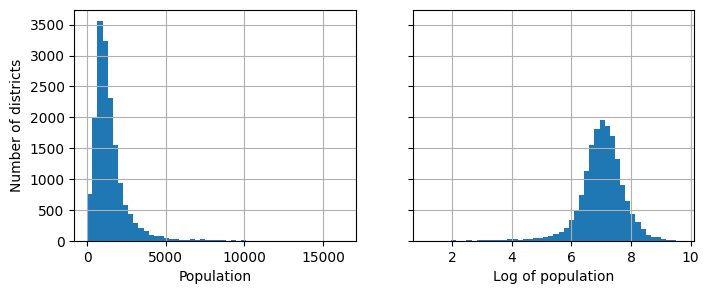

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

Another approach to handle heavy-tailed features consists in bucketizing the feature. For example, you could replace each value with its percentile.

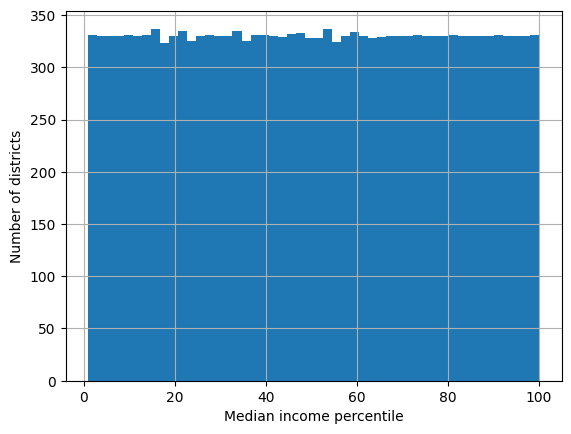

In [142]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

When a feature has a multimodal distribution (i.e., with two or more clear peaks, called modes), such as the housing_median_age feature, it can also be helpful to bucketize it, but this time treating the bucket IDs as categories, rather than as numerical values. This means that the bucket indices must be encoded, for example using a OneHotEncoder. This approach will allow the regression model to more easily learn different rules for different ranges of this feature value.

Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity
measure is typically computed using a radial basis function (RBF)—any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point.

For example, the Gaussian RBF similarity between the housing age x and 35 is given by the equation exp(–γ(x – 35)²). The hyperparameter γ (gamma) determines how quickly the similarity measure decays as x moves away from 35. Using Scikit-Learn’s rbf_kernel() function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

In [140]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

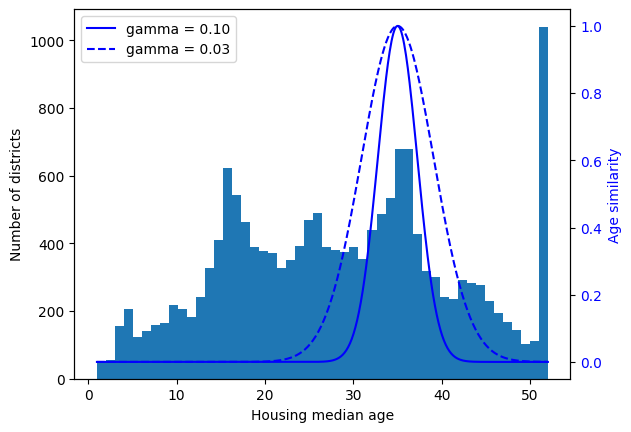

In [144]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

We can see this new feature as a function of the housing median age (solid line). It also shows what the feature would look like if you used a smaller gamma value. As the chart shows, the new age similarity feature peaks at 35, right around the spike in the housing median age distribution: if this particular age group is well correlated with lower prices, there’s a good chance that this new feature will help.

So far we’ve only looked at the input features, but the target values may also need to be transformed

For example, if the target distribution has a heavy tail, you may choose to replace the target with its logarithm. But if you do, the regression model will now predict the log of the median house value, not the median house value itself. You will need to compute the exponential of the model’s prediction if you want the predicted median house value. Luckily, most of Scikit-Learn’s transformers have an inverse_transform() method, making it easy to compute the inverse of their transformations.

For example, the following code example shows how to scale the labels using a StandardScaler (just like we did for inputs), then train a simple linear regression model on the resulting scaled labels and use it to make predictions on some new data, which we transform back to the original scale using the trained scaler’s inverse_transform() method.

Note that we convert the labels from a Pandas Series to a DataFrame, since the StandardScaler expects 2D inputs. Also, in this example we just train the model on a single raw input feature (median income), for simplicity:

In [145]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [146]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

This works fine, but a simpler option is to use a TransformedTargetRegressor. We just need to construct it, giving it the regression model and the label transformer, then fit it on the training set, using the original unscaled labels. It will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels. Then, when we want to make a prediction, it will call the regression model’s predict() method and use the scaler’s inverse_transform() method to produce the prediction:

In [147]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [148]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

1.3.4.4 Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom transformations, cleanup operations, or combining specific attributes.

For transformations that don’t require any training, you can just write a function that takes a NumPy array as input and outputs the transformed array.

In [149]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

The inverse_func argument is optional. It lets you specify an inverse transform function, e.g., if you plan to use your transformer in a TransformedTargetRegressor.

In [150]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [151]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

Note that rbf_kernel() does not treat the features separately. If you pass it an array with two features, it will measure the 2D distance (Euclidean) to measure similarity.

In [152]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [153]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

Custom transformers are also useful to combine features. For example, here’s a FunctionTransformer that computes the ratio between the input features 0 and 1:

In [154]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

FunctionTransformer is very handy, but what if you would like your transformer to be trainable, learning some parameters in the fit() method and using them later in the transform() method? For this, you need to write a custom class. Scikit-Learn relies on duck typing, so this class does not have to inherit from any particular base class. All it needs is three methods: fit() (which must return self), transform(), and fit_transform().

In [155]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

A custom transformer can (and often does) use other estimators in its implementation. For example, the following code demonstrates custom transformer that uses a KMeans clusterer in the fit() method to identify the
main clusters in the training data, and then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center:

In [156]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

You can check whether your custom estimator respects Scikit-Learn’s API by passing an instance to check_estimator() from the sklearn.utils.estimator_checks package. For the full API, check out https://scikit-learn.org/stable/developers.

In [168]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

This code creates a ClusterSimilarity transformer, setting the number of clusters to 10. Then it calls fit_transform() with the latitude and longitude of every district in the training set, weighting each district by its median house value. The transformer uses k-means to locate the clusters, then measures the Gaussian RBF similarity between each district and all 10 cluster centers. The result is a matrix with one row per district, and one column per cluster. Let’s look at the first three rows, rounding to two decimal places:

In [169]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

Next figure shows the 10 cluster centers found by k-means. The districts are colored according to their geographic similarity to their closest cluster center. As you can see, most clusters are located in highly populated and expensive areas.

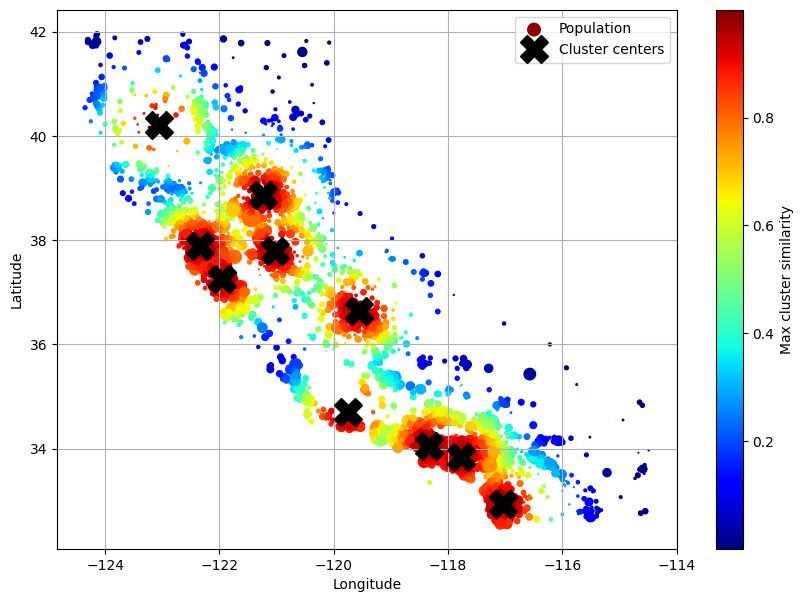

In [170]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

1.3.4.5 Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for numerical attributes, which will first impute then scale the input features:

In [171]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

The estimators must all be transformers (i.e., they must have a fit_transform() method), except for the last one, which can be anything: a transformer, a predictor, or any other type of estimator.

If you don’t want to name the transformers, you can use the make_pipeline() function instead; it takes transformers as positional arguments and creates a Pipeline using the names of the transformers’ classes, in lowercase and without underscores (e.g., "simpleimputer"):

In [172]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all the transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it just calls the fit() method.

The pipeline exposes the same methods as the final estimator.

Let’s call the pipeline’s fit_transform() method and look at the output’s first two rows, rounded to two decimal places:

In [173]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [174]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

if you want to recover a nice DataFrame, you can use the pipeline’s get_feature_names_out() method:

In [176]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer capable of handling all columns, applying the appropriate transformations to each column. For this, you can use a ColumnTransformer.

In [177]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Since listing all the column names is not very convenient, Scikit-Learn provides a make_column_selector() function that returns a selector function you can use to automatically select all the features of a given type, such as numerical or categorical.

In [178]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Now we’re ready to apply this ColumnTransformer to the housing data:

In [179]:
housing_prepared = preprocessing.fit_transform(housing)

We have a preprocessing pipeline that takes the entire training dataset and applies each transformer to the appropriate columns, then concatenates the transformed columns horizontally (transformers must never change the number of rows). Once again this returns a NumPy array, but you can get the column names using preprocessing.get_feature_names_out() and wrap the data in a nice DataFrame.

In [180]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


Let’s recap what the pipeline will do and why:

1. Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don’t expect missing values. In categorical features, missing values will be replaced by the most frequent category.
2. The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs.
3. A few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, and people_per_house. Hopefully these will better correlate with the median house value, and thereby help the ML models.
4. A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.
5. Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions.
6. All numerical features will be standardized, as most ML algorithms prefer when all features have roughly the same scale.

The code that builds the pipeline to do all of this should look like this:

In [181]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age+


In [182]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 25)

In [ ]:
preprocessing.get_feature_names_out()